In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from modules.utilityFunctions import plotMomentScaling, fitMoments, plotCorrelationMeanSize, cumulative_data, susmanProcessing, tanouchiProcessing
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from typing import Union, List, Callable
from tqdm.notebook import tqdm_notebook
from matplotlib.ticker import FormatStrFormatter
from modules.visualizationTS import systemHandling
from modules.simulations import simulation
import matplotlib.image as mpimg
from scipy.stats import gamma

## Active Phase


In [3]:
dataPath = Path.cwd().parents[1] / 'data'
activeHPath: Path = dataPath / 'positiveH' / 'activeHHDeciding'

fitActiveH: pd.DataFrame = pd.read_csv(
    activeHPath / 'momentScaling' / 'momentsFit.csv')
meansActiveH: np.array = np.load(
    activeHPath / 'momentScaling' / 'allMeans.npy')
momentsActiveH: np.array = np.load(
    activeHPath / 'momentScaling' / 'allMoments.npy')

,linear,log
k=2,4.966080,1.949697
k=3,21.823808,2.854356


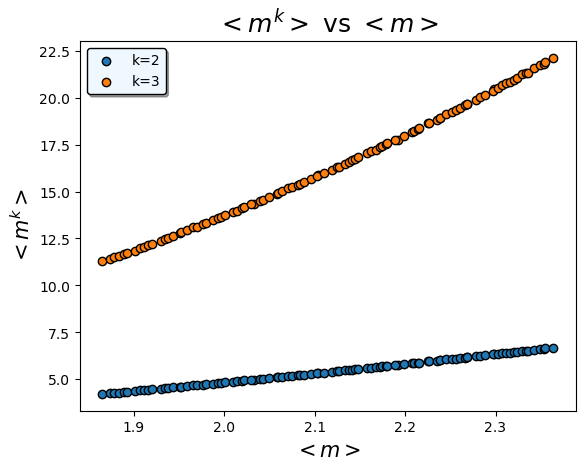

In [7]:
plotMomentScaling(activeHPath / 'momentScaling')
fitDictionary = fitMoments(activeHPath / 'momentScaling')
pd.DataFrame(fitDictionary)

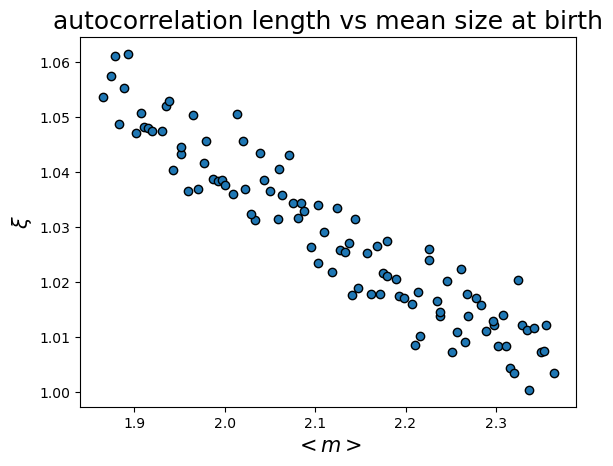

In [8]:
plotCorrelationMeanSize(activeHPath)

## Slopes power law


In [9]:
with open(dataPath / 'slopesMoments.json', mode='r') as f:
    slopesData = json.load(f)

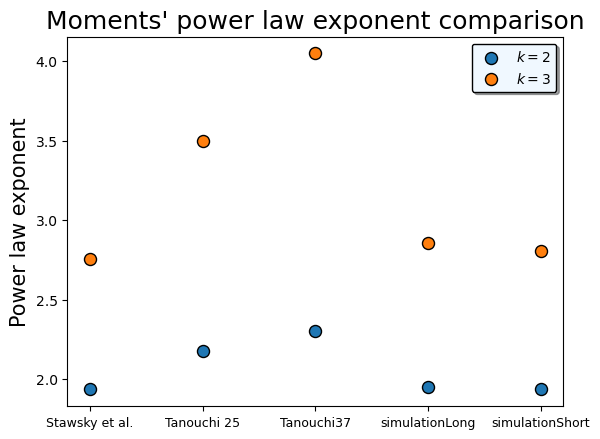

In [10]:
keysDict = list(slopesData.keys())
allSecondMoments = [slopesData[key]['2'] for key in keysDict]
allThirdMoments = [slopesData[key]['3'] for key in keysDict]

plt.scatter(keysDict, allSecondMoments,
            label='$k = 2$', edgecolor='black', s=75)
plt.scatter(keysDict, allThirdMoments,
            label='$k = 3$', edgecolor='black', s=75)
plt.ylabel('Power law exponent', fontsize=15)
plt.legend(facecolor='aliceblue', shadow=True, edgecolor='black')
_ = plt.title('Moments\' power law exponent comparison', fontsize=18)
plt.tick_params(axis='x', which='major', labelsize=9)

## Visualizaion linear fit


,linear,log
k=2,4.939073,1.948487
k=3,21.597016,2.851848


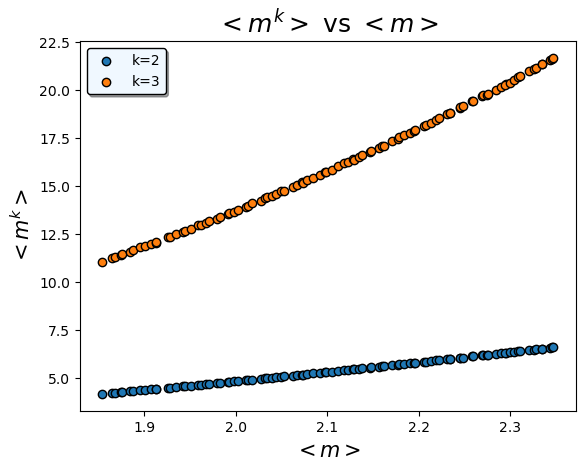

In [11]:
dataPath = Path.cwd().parents[1] / 'data'
absorbingHPath: Path = dataPath / 'positiveH' / 'absorbingHCloserToCritical'
plotMomentScaling(absorbingHPath / 'momentScaling')
fitDictionary = fitMoments(absorbingHPath / 'momentScaling')
pd.DataFrame(fitDictionary)
# plt.xscale('log')
# plt.yscale('log')

## Protein Simulation


,linear,log
k=2,4.896070,1.905755
k=3,21.687436,2.726321


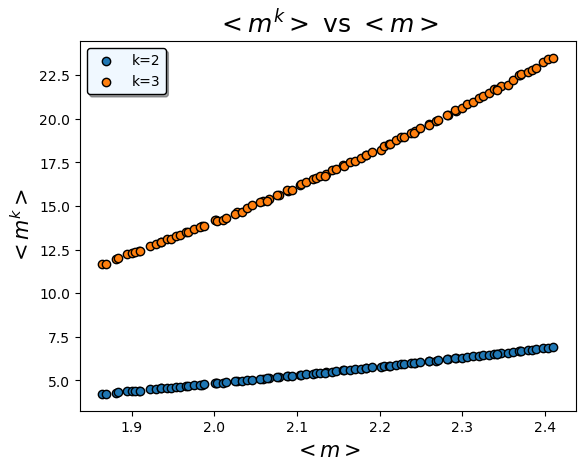

In [12]:
dataPath = Path.cwd().parents[1] / 'data'
proteinPath: Path = dataPath / 'twoTrait' / 'proteinSimulation'
plotMomentScaling(proteinPath / 'momentScaling')
fitDictionary = fitMoments(proteinPath / 'momentScaling')
pd.DataFrame(fitDictionary)

## MSE visualization


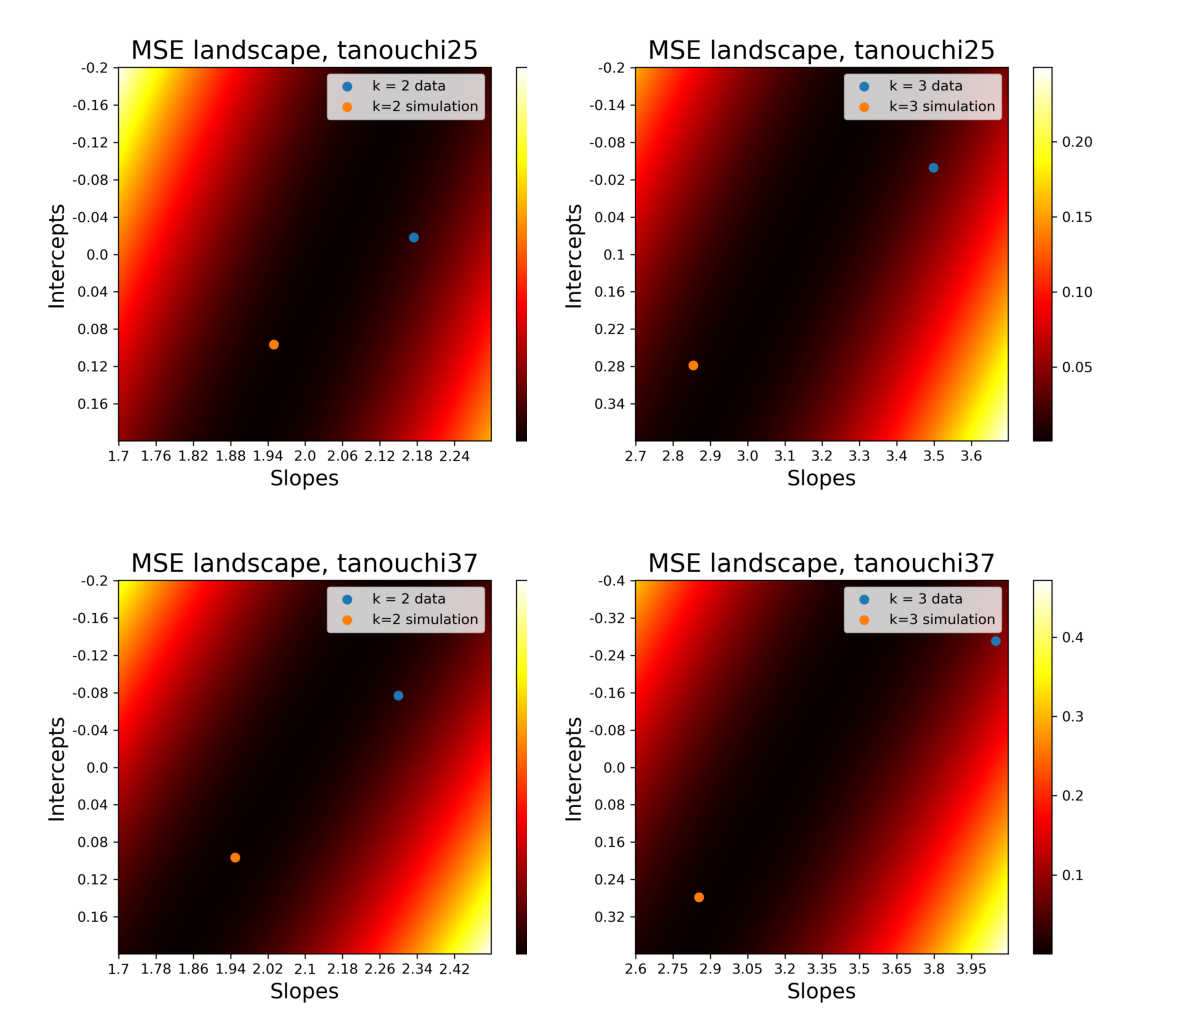

In [13]:
imgTanouchi252 = mpimg.imread('../../data/images/heatmaps/tanouchi252.png')
imgTanouchi253 = mpimg.imread('../../data/images/heatmaps/tanouchi253.png')
imgTanouchi372 = mpimg.imread('../../data/images/heatmaps/tanouchi372.png')
imgTanouchi373 = mpimg.imread('../../data/images/heatmaps/tanouchi373.png')

fig, ax_ = plt.subplots(2, 2, figsize=(15, 20))
axFlatten = ax_.flatten()
axFlatten[0].imshow(imgTanouchi252)
axFlatten[1].imshow(imgTanouchi253)
axFlatten[2].imshow(imgTanouchi372)
axFlatten[3].imshow(imgTanouchi373)

for ax in axFlatten:
    ax.axis('off')

plt.subplots_adjust(wspace=-.2, hspace=-.5)

## GAN data


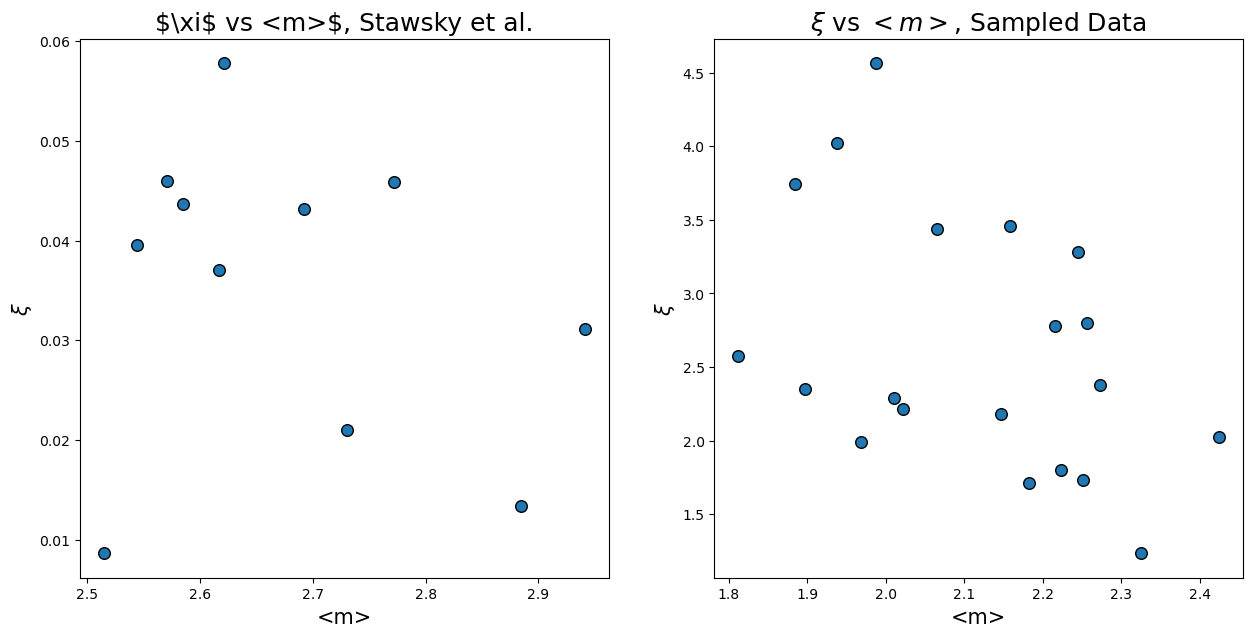

In [14]:
susmanPath = '/Users/tommaso/Desktop/masterThesis/data/realData/Susman/longLineages/susmanDataLL.csv'
originalDataSusman = susmanProcessing(susmanPath)
originalDataSimulationPath = dataPath / \
    'positiveH' / 'absorbingHHDecidingShort'
originalDataSimulation = np.load(
    originalDataSimulationPath / 'timeSerieses.npy')[::5, :].T

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].scatter(np.mean(originalDataSusman.T, axis=1), pd.read_csv(
    dataPath / 'ML' / 'timeGAN' / 'susman' / 'correlationParameters.csv')['correlation'], s=70, edgecolor='black')
ax[1].scatter(np.mean(np.exp(originalDataSimulation.T), axis=1), pd.read_csv(
    dataPath / 'positiveH' / 'absorbingHHDecidingShort' / 'correlationParametersSampledData.csv')['correlation'],
    s=70, edgecolor='black')

ax[0].set_title('$\\xi$ vs <m>$, Stawsky et al.', fontsize=18)
ax[0].set_xlabel('<m>', fontsize=15)
ax[0].set_ylabel('$\\xi$', fontsize=15)

ax[1].set_title('$\\xi$ vs $<m>$, Sampled Data', fontsize=18)
ax[1].set_xlabel('<m>', fontsize=15)
_ = ax[1].set_ylabel('$\\xi$', fontsize=15)

## Bayesian Inference Data


In [16]:
ourValues = {'gamma': 1.2268 / ((30.4743 - 1) * 0.0458), 'h': 0.5455/0.5787}
alphaGuler = (1.4362**2) / (0.0653**2)
betaGuler = alphaGuler / 1.4362
guler = {'gamma':1.2772 / ((alphaGuler - 1) / (betaGuler)), 'h':0.5241 / 0.5835}

def plotBayesianData(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    ax[0].scatter(range(len(df)), df['w2'] /
                  (((df['a'] - 1) * df['b'])), edgecolor='black')
    if title == 'Stawsky':
        ax[0].axhline(ourValues['gamma'])
        ax[0].axhline(guler['gamma'])

    ax[0].set_xlabel('lineage Id', fontsize=15)
    ax[0].set_ylabel('$\\gamma$', fontsize=15)
    ax[0].set_title(title + ' $\\gamma$', fontsize=18)

    ax[1].scatter(range(len(df)), df['u'] / df['v'], edgecolor='black')
    if title == 'Stawsky':
        ax[1].axhline(ourValues['h'])
        ax[0].axhline(guler['h'])
    ax[1].set_xlabel('lineage Id', fontsize=15)
    ax[1].set_ylabel('$h$', fontsize=15)
    ax[1].set_title(title + ' $h$', fontsize=18)

    return fig, ax

In [17]:
bayesianPath = '/Users/tommaso/Desktop/masterThesis/data/bayesianInference/'
tanouchi25Bayesian = pd.read_csv(
    bayesianPath + 'tanouchi25c_export_run_770781.csv')
tanouchi37Bayesian = pd.read_csv(
    bayesianPath + 'tanouchi37c_export_run_770781.csv')
susmanBayesian = pd.read_csv(bayesianPath + 'susman18_export_run_770781.csv')

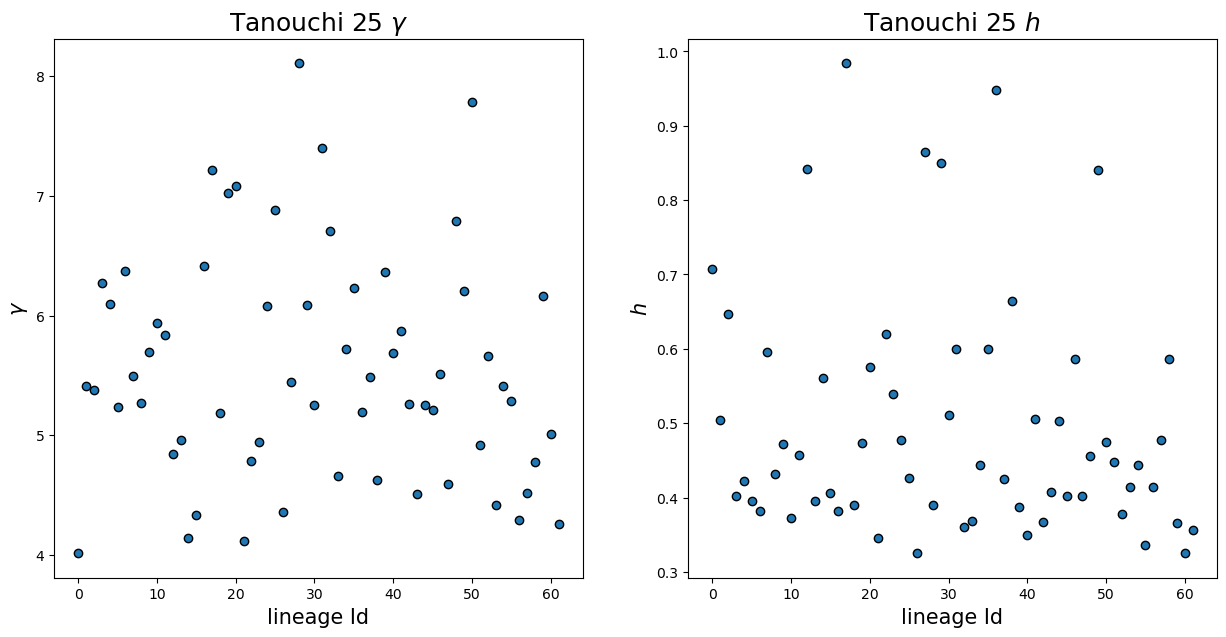

In [18]:
_ = plotBayesianData(tanouchi25Bayesian, 'Tanouchi 25')

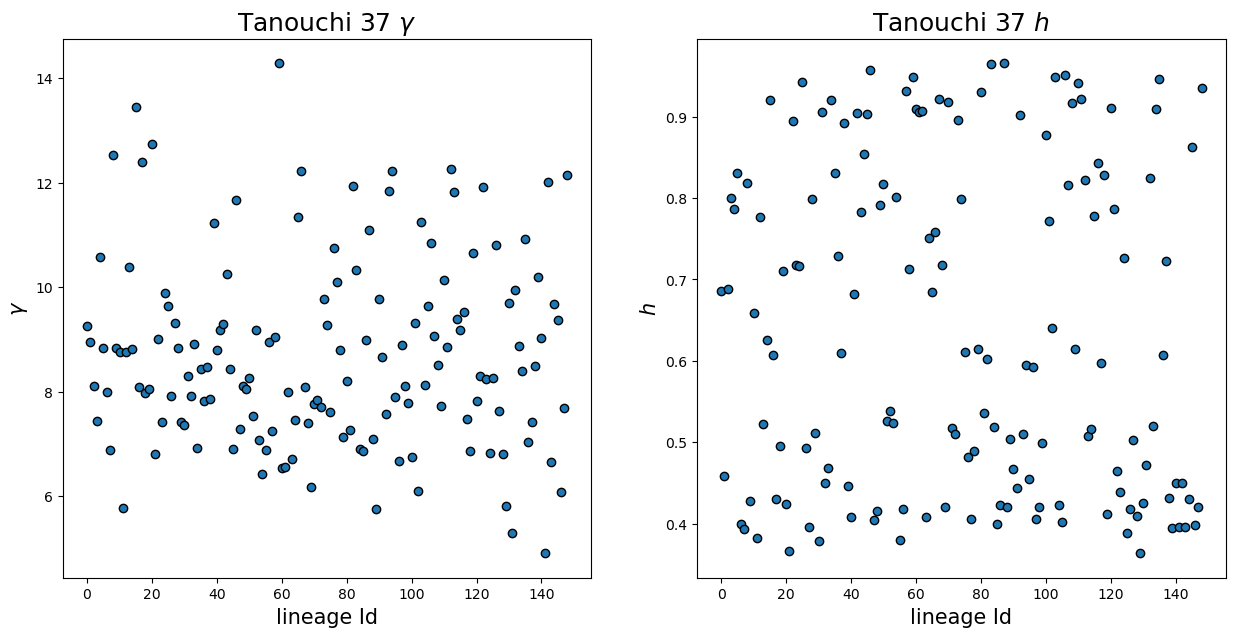

In [19]:
_ = plotBayesianData(tanouchi37Bayesian, 'Tanouchi 37')

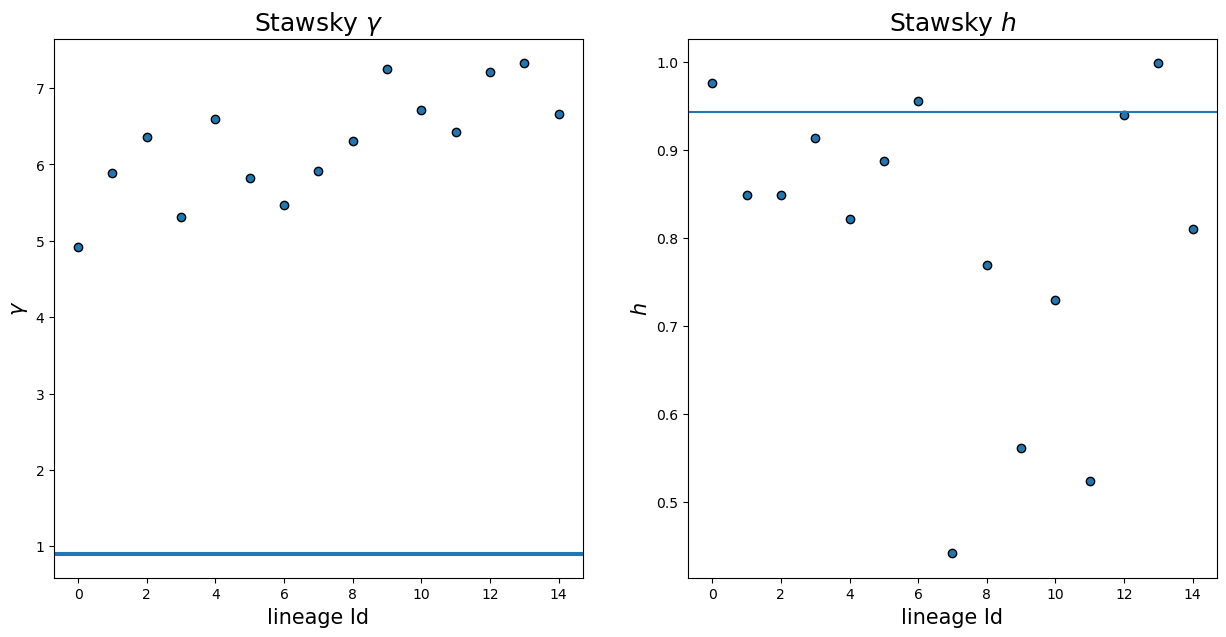

In [20]:
_ = plotBayesianData(susmanBayesian, 'Stawsky')

In [5]:

ganPath = dataPath / 'ML' / 'timeGAN' / \
    'tanouchi25' / 'sampledDataTanouchi.npy'
sampledData: np.ndarray = np.load(ganPath)
reshapedData = sampledData.reshape(
    (sampledData.shape[0] * sampledData.shape[1], sampledData.shape[2]))
originalDataPath = dataPath / \
    'realData' / 'Tanouchi' / 'Tanouchi25' / 'Tanouchi25C.csv'
#originalData = np.load(originalDataPath / 'timeSerieses.npy')[::5, :].T
originalData = tanouchiProcessing(originalDataPath, seq_len=0)
scaler = MinMaxScaler().fit(originalData)
rescaledSampledData = scaler.inverse_transform(reshapedData)
ganPathReshaped = dataPath / 'ML' / \
    'timeGAN' / 'tanouchi25' / 'sampledDataReshaped.npy'
np.save(ganPathReshaped, rescaledSampledData.T)
